### Responsible Data Science Course Project: Nutritional Labels for Automated Decision Systems

Rohan Mahadev - rm5310, Anindya Chakravarti - ac8184

In [3]:
import os
import yaml
import pickle
import argparse

import numpy as np
import torch
torch.backends.cudnn.benchmark=True
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from PIL import Image

from datasets import LabeledImages
from models.se_resnet import se_resnet101
# Helper functions to draw predictions:

import torchvision.transforms as T

import pandas as pd

from lime import lime_image

from skimage.segmentation import mark_boundaries

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
CONFIG_PATH = './config.yaml'

# ADS being evaluated

In [5]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.n_classes = n_classes
        self.features = se_resnet101()
        self.classifier = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class ModelWithLoss(nn.Module):
    def __init__(self, classifier):
        super(ModelWithLoss, self).__init__()
        self.classifier = classifier
        self.criterion = nn.CrossEntropyLoss(size_average=False)

    def forward(self, x, labels):
        assert len(x) == len(labels)

        predictions = self.classifier(x)

        all_classes = np.arange(self.classifier.n_classes, dtype=np.int64)
        zero_label = torch.tensor([0]).to(x.device)

        loss = 0
        denominator = 0
        for prediction, positives in zip(predictions, labels):
            negatives = np.setdiff1d(all_classes, positives, assume_unique=True)
            negatives_tensor = torch.tensor(negatives).to(x.device)
            positives_tensor = torch.tensor(positives).to(x.device).unsqueeze(dim=1)

            for positive in positives_tensor:
                indices = torch.cat((positive, negatives_tensor))
                loss = loss + self.criterion(prediction[indices].unsqueeze(dim=0), zero_label)
                denominator += 1

        loss /= denominator

        return loss

    def predict(self, x):
        input_shape = x.shape
        if len(input_shape) == 5:
            x = x.view(-1, input_shape[2], input_shape[3], input_shape[4])
            predictions = self.classifier(x)
            predictions = predictions.view(input_shape[0], input_shape[1], -1).mean(dim=1)
        else:
            predictions = self.classifier(x)

        return predictions

In [6]:
with open(CONFIG_PATH, 'r') as f:
    config = yaml.load(f)

In [7]:
dataset_root = config['DATASET']['STAGE2_TEST_IMAGES_ROOT']

In [8]:
assert os.path.exists(dataset_root), dataset_root
sample_submission_path = config['DATASET']['STAGE{}_SAMPLE_SUBMISSION_PATH'.format(2)]
assert os.path.exists(sample_submission_path), sample_submission_path

output_root = config['SUBMISSION']['OUTPUT_ROOT']
assert os.path.exists(output_root), output_root

test_list_path = os.path.join(output_root, 'test_stage{}.txt'.format(2))

In [9]:
with open(config['DATASET']['NAME_TO_LABEL_PATH'], 'rb') as f:
    name_to_label = pickle.load(f)
label_to_name = {label: name for name, label in name_to_label.items()}
n_classes = len(name_to_label)

In [10]:
classifier = Classifier(n_classes)
model = ModelWithLoss(classifier).to(device).eval()

/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [11]:
snapshot_path = os.path.join(config['TUNING']['ARTIFACTS_ROOT'], 'snapshots',
                                 'snapshot_epoch_{}.pth.tar'.format(config['TUNING']['N_EPOCH']))
state = torch.load(snapshot_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state['model'])

<All keys matched successfully>

In [12]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = T.Compose([T.ToTensor(), normalize])

In [13]:
description = pd.read_csv('../../class-descriptions2.csv')
label_lookup = {label: descr for label, descr in zip(description.label_code.values, description.description.values)}

In [14]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [15]:
def run_pred(path):    
    img = get_image(path)
    transform = T.Compose([T.Resize(256),T.CenterCrop(224),
                           to_tensor])
    img1 = transform(img)
    img1 = img1.unsqueeze(0)

    with torch.no_grad():
        pred_scores = model.predict(img1.to(device))
        return pred_scores

In [16]:
def detailed_preds(path):
    probs = run_pred(path)
    scores, labels = probs.sort(dim=1, descending=True)
    names = [label_lookup[label_to_name[label.item()]] for label in labels[0]]
    return names

get label numbers of man,boy,girl,woman

In [17]:
print("Man", description[description.description == 'Man'].label_code)
print("Woman", description[description.description == 'Woman'].label_code)
print("Boy", description[description.description == 'Boy'].label_code)
print("Girl", description[description.description == 'Girl'].label_code)

Man 10693    /m/04yx4
Name: label_code, dtype: object
Woman 7212    /m/03bt1vf
Name: label_code, dtype: object
Boy 876    /m/01bl7v
Name: label_code, dtype: object
Girl 11877    /m/05r655
Name: label_code, dtype: object


In [18]:
print("Man", name_to_label['/m/04yx4'])
print("Woman", name_to_label['/m/03bt1vf'])
print("Boy", name_to_label['/m/01bl7v'])
print("Girl", name_to_label['/m/05r655'])

Man 54
Woman 41
Boy 9
Girl 58


# MR2 stuff (need to get the names value)

In [42]:
mr2_data = pd.read_csv("../../dataset.csv")

In [43]:
y_pred = []

In [44]:
labels_list = {
    "Girl" : 0, 
    "Woman" : 0,
    "Man" : 1,
    "Boy" : 1
}

In [45]:
for name in mr2_data.name:
    prediction_list = detailed_preds("../../MR2 faces/"+name+".tif")
    for pred_name in prediction_list:
        if pred_name in labels_list.keys():
            y_pred.append(labels_list[pred_name])
            break
mr2_data["Predictions"] = y_pred

In [46]:
mr2_data["Flagged"] = [False]*mr2_data.shape[0]

In [48]:
mr2_data.loc[(mr2_data['Predictions'] == 1) & (mr2_data['sex'] == "Female"), "Flagged"] = True

In [49]:
mr2_data.loc[(mr2_data['Predictions'] == 0) & (mr2_data['sex'] == "Male"), "Flagged"] = True

In [73]:
mr2_data[(mr2_data["Flagged"] == False) & (mr2_data["sex"] == "Female")]

,name,race,sex,Predictions,Flagged
0,wf03,European,Female,0,False
1,af07,Asian,Female,0,False
5,af06,Asian,Female,0,False
12,af11,Asian,Female,0,False
13,wf01,European,Female,0,False
14,wf11,European,Female,0,False
15,wf05,European,Female,0,False
16,af01,Asian,Female,0,False
21,wf04,European,Female,0,False
23,wf06,European,Female,0,False


# Fairness

# LIME

In [30]:
def get_pil_transform(): 
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = T.Compose([
        T.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [31]:
def batch_pred(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    with torch.no_grad():
        pred_scores = model.predict(batch.to(device))
        return pred_scores.detach().cpu().numpy()

In [32]:
def get_lime_man(path):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_pred, # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(54, positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)
    
def get_lime_woman(path):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_pred, # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(41, positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)

def get_lime_boy(path):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_pred, # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(9, positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)

def get_lime_girl(path):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_pred, # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(58, positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)

CPU times: user 2min 30s, sys: 3min 16s, total: 5min 47s
Wall time: 1min 28s


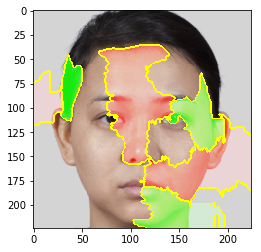

In [33]:
%%time
get_lime_woman("../../MR2 faces/af10.tif")

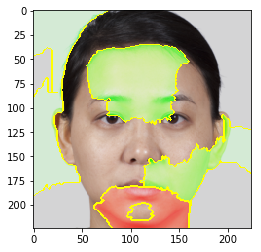

In [65]:
get_lime_man("../../MR2 faces/af10.tif")

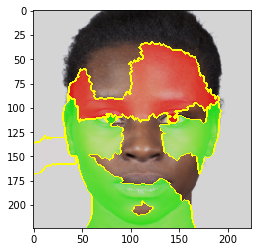

In [67]:
get_lime_woman("../../MR2 faces/bf15.tif")

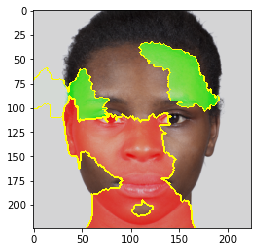

In [68]:
get_lime_man("../../MR2 faces/bf15.tif")

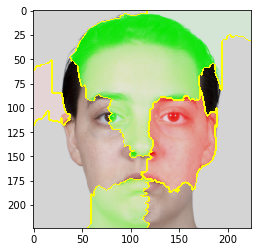

In [69]:
get_lime_woman("../../MR2 faces/wf10.tif")

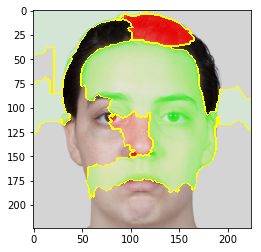

In [70]:
get_lime_man("../../MR2 faces/wf10.tif")

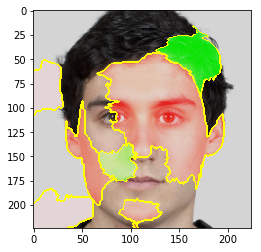

In [71]:
get_lime_woman("../../MR2 faces/wm06.tif")

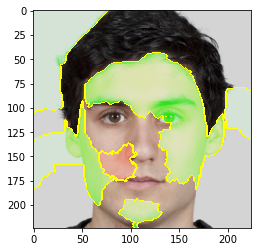

In [72]:
get_lime_man("../../MR2 faces/wm06.tif")

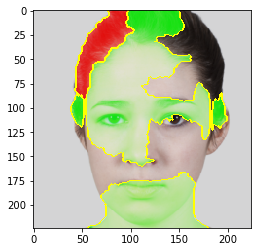

In [74]:
get_lime_woman("../../MR2 faces/wf04.tif")

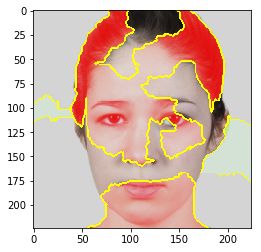

In [75]:
get_lime_man("../../MR2 faces/wf04.tif")